# Data Analysis of RSNA Library

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.patches as patches
import os
import cv2
from tqdm import tqdm

print(os.listdir("../input"))

['stage_2_test_images', 'stage_2_sample_submission.csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_images', 'stage_2_train_labels.csv', 'GCP Credits Request Link - RSNA.txt']


In [6]:
import pydicom # Read, modify and write DICOM files with python code
import matplotlib.pyplot as plt

In [7]:
random_stat = 123
np.random.seed(random_stat)

# Load the dataset

In [8]:
!ls ../input

GCP Credits Request Link - RSNA.txt  stage_2_test_images
stage_2_detailed_class_info.csv      stage_2_train_images
stage_2_sample_submission.csv	     stage_2_train_labels.csv


## Labels

In [9]:
df = pd.read_csv('../input/stage_2_train_labels.csv')
print(df.head(5))
print(f'The total number of trianing examples: {len(df)}')

                              patientId      x   ...    height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN   ...       NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN   ...       NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN   ...       NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN   ...       NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0   ...     379.0       1

[5 rows x 6 columns]
The total number of trianing examples: 30227


1. Positive example: target == 0 (No pneumonia)

In [10]:
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


1. Negative example: target == 1 (has pneumonia)
 * Note: a positive example may have mulitple bboxes

In [11]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


## Input data and dimension

In [12]:
patientId = df['patientId'][0]
dcm_file = '../input/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [13]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


### Prepare a small set of data (2000)

In [14]:
NUM_OF_DATA = 2000

In [15]:
print(len(df['patientId']))

30227


In [16]:
df['patientId'][0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [17]:
small_patient_ids = df['patientId'][:NUM_OF_DATA]
training_images = []
training_labels = []
for patient_id in small_patient_ids:
    dcm_file = f'../input/stage_2_train_images/{patient_id}.dcm'
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    training_images.append(im)
    training_labels.append(df[df['patientId']==patient_id].values)
    

### Visualize the training image with boundingbox

[['00436515-870c-4b36-a041-de91049b9ab4' 264.0 152.0 213.0 379.0 1]
 ['00436515-870c-4b36-a041-de91049b9ab4' 562.0 152.0 256.0 453.0 1]]


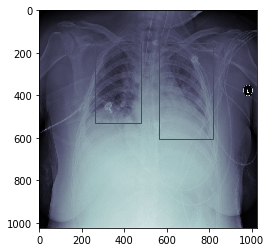

In [18]:
sample_index = 4
im = training_images[sample_index]
fig,ax = plt.subplots(1)
for bbox in range(len(training_labels[sample_index])):
    bx, by, bh, bw = [i for i in training_labels[sample_index][bbox][1:5]]
    # Display the image
    ax.imshow(im, cmap=plt.cm.bone)
    # Create a Rectangle patch
    rect = patches.Rectangle((bx, by), bh, bw ,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
print(training_labels[sample_index])
plt.show()


### Darknet

In [19]:
!git clone https://github.com/pjreddie/darknet

# Build gpu version darknet
!cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

# -j <The # of cpu cores to use>. Chang 999 to fit your environment. Actually i used '-j 50'.
!cd darknet && make -j 999 -s
!cp darknet/darknet darknet_gpu

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.14 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (3945/3945), done.
Checking connectivity... done.


### Prepare data for YOLO3

In [20]:
DATA_DIR = "../input"

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(os.getcwd(), "images")  # .jpg
label_dir = os.path.join(os.getcwd(), "labels")  # .txt
metadata_dir = os.path.join(os.getcwd(), "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(os.getcwd(), "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(os.getcwd(), "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [21]:
!ls -shtl

total 1.9M
4.0K drwxr-xr-x  2 root root 4.0K Oct 29 21:56 backup
4.0K drwxr-xr-x  2 root root 4.0K Oct 29 21:56 cfg
4.0K drwxr-xr-x  2 root root 4.0K Oct 29 21:56 images
4.0K drwxr-xr-x  2 root root 4.0K Oct 29 21:56 labels
4.0K drwxr-xr-x  2 root root 4.0K Oct 29 21:56 metadata
1.9M -rwxr-xr-x  1 root root 1.9M Oct 29 21:55 darknet_gpu
4.0K drwxr-xr-x 13 root root 4.0K Oct 29 21:55 darknet
4.0K -rw-r--r--  1 root root  199 Oct 29 21:54 __notebook_source__.ipynb


## Generate  .txt file for YOLO3

In [23]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [27]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
    
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [30]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [02:18<00:00, 218.45it/s]


In [31]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [ ]:
# Following lines do not contain data with no bbox
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)